<a href="https://colab.research.google.com/github/Andreaierardi/Algorithm-for-Massive-Datasets/blob/main/AMD_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

# **Market Basket Analysis**


---
<br>

## Algorithm for Massive Datasets project

### University of Milan
### Data Science and Economics

<br>
<br>

**Author**: Andrea Ierardi


Student's ID: 960188

https://spark.apache.org/docs/2.4.0/sql-pyspark-pandas-with-arrow.html
https://towardsdatascience.com/a-brief-introduction-to-pyspark-ff4284701873

https://medium.com/@pcm1312/implementing-fp-growth-in-python-170f3dc64d78
https://github.com/mehulagrawal/Apriori_and_FP-Growth/tree/master/Source
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/
https://towardsdatascience.com/fp-growth-frequent-pattern-generation-in-data-mining-with-python-implementation-244e561ab1c3

<br>
<br>

# **Dataset download using Kaggle API**

In [2]:
#!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"


%cd /content/gdrive/My Drive/Kaggle




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/19aHkdJBcyNlvKaxw7bq5NLu3yAmjGDbC/Kaggle


In [4]:
#!kaggle datasets download -d ashirwadsangwan/imdb-dataset

In [5]:
#!unzip imdb-dataset.zip

<br>
<br>

# Spark Initialisation

In [6]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 17.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=f3200a317e9ee26769372b102852c51b4cf5d0941dd78807df364a9db29a63ac
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [8]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [9]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [10]:
ratings = spark.read.csv("title.ratings.tsv/title.ratings.tsv",sep=r'\t', header=True, inferSchema=True)
basics = spark.read.csv("title.basics.tsv/title.basics.tsv", sep=r'\t', header = True , inferSchema=True)
names = spark.read.csv("name.basics.tsv/name.basics.tsv",sep=r'\t', header=True, inferSchema=True)
principals = spark.read.csv("title.principals.tsv/title.principals.tsv",sep=r'\t', header=True, inferSchema=True)
akas = spark.read.csv("title.akas.tsv/title.akas.tsv",sep=r'\t', header=True, inferSchema=True)


In [11]:
ratings.createOrReplaceTempView("ratings")
basics.createOrReplaceTempView("basics")
names.createOrReplaceTempView("names")
principals.createOrReplaceTempView("principals")
akas.createOrReplaceTempView("akas")

In [12]:
akas.show(5)

+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|  titleId|ordering|               title|region|language|      types|attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|tt0000001|       1|Carmencita - span...|    HU|      \N|imdbDisplay|        \N|              0|
|tt0000001|       2|          Καρμενσίτα|    GR|      \N|         \N|        \N|              0|
|tt0000001|       3|          Карменсита|    RU|      \N|         \N|        \N|              0|
|tt0000001|       4|          Carmencita|    US|      \N|         \N|        \N|              0|
|tt0000001|       5|          Carmencita|    \N|      \N|   original|        \N|              1|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
only showing top 5 rows



In [13]:
names.show(n=10)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
|nm0000006| Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0038109,tt00368...|
|nm0000007|Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0043265,tt00338...|
|nm0000008|  Marlon Brando|     1924|     2004|actor,soundtrack,...|tt0070849,tt00787...|
|nm0000009

In [14]:
basics.show(n = 5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [15]:
ratings.show(n = 5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.6|    1550|
|tt0000002|          6.1|     186|
|tt0000003|          6.5|    1207|
|tt0000004|          6.2|     113|
|tt0000005|          6.1|    1934|
+---------+-------------+--------+
only showing top 5 rows



In [16]:
principals.show(n = 5)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows



In [17]:
akas.show(n = 5)

+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|  titleId|ordering|               title|region|language|      types|attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|tt0000001|       1|Carmencita - span...|    HU|      \N|imdbDisplay|        \N|              0|
|tt0000001|       2|          Καρμενσίτα|    GR|      \N|         \N|        \N|              0|
|tt0000001|       3|          Карменсита|    RU|      \N|         \N|        \N|              0|
|tt0000001|       4|          Carmencita|    US|      \N|         \N|        \N|              0|
|tt0000001|       5|          Carmencita|    \N|      \N|   original|        \N|              1|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
only showing top 5 rows



In [18]:
akas.printSchema()

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)



<br>
<br>

# Data Cleaning

In [19]:
#import pandas as pd

In [20]:
#names = pd.read_csv("name.basics.tsv/name.basics.tsv", sep='\t')

In [21]:
#names

In [22]:
#ratings = pd.read_csv("title.ratings.tsv/title.ratings.tsv", sep='\t')

In [23]:
#ratings

In [24]:
#principals = pd.read_csv("title.principals.tsv/title.principals.tsv", sep='\t')

In [25]:
#principals.head(10)

In [26]:
#basics = pd.read_csv("title.basics.tsv/title.basics.tsv", sep='\t')

In [27]:
#basics.head(10)

In [28]:
#akas = pd.read_csv("title.akas.tsv/title.akas.tsv", sep='\t')

In [29]:
#dir(spark.sql)

In [30]:
query = """SELECT COUNT(category) 
           FROM principals
           WHERE category = 'actor'
            """

res = spark.sql(query)
res.show()

+---------------+
|count(category)|
+---------------+
|        8493701|
+---------------+



In [31]:
filter_principals = principals.filter( (principals.category == "actor") | (principals.category == "actress"))

In [32]:
filter_principals.show(200)

+---------+--------+----------+--------+---+--------------------+
|   tconst|ordering|    nconst|category|job|          characters|
+---------+--------+----------+--------+---+--------------------+
|tt0000005|       1| nm0443482|   actor| \N|      ["Blacksmith"]|
|tt0000005|       2| nm0653042|   actor| \N|       ["Assistant"]|
|tt0000007|       1| nm0179163|   actor| \N|                  \N|
|tt0000007|       2| nm0183947|   actor| \N|                  \N|
|tt0000008|       1| nm0653028|   actor| \N|    ["Sneezing Man"]|
|tt0000009|       1| nm0063086| actress| \N|["Miss Geraldine ...|
|tt0000009|       2| nm0183823|   actor| \N|    ["Mr. Hamilton"]|
|tt0000009|       3| nm1309758|   actor| \N|["Chauncey Depew ...|
|tt0000011|       1| nm3692297|   actor| \N|        ["Acrobats"]|
|tt0000014|       1| nm0166380|   actor| \N|    ["The Gardener"]|
|tt0000014|       2| nm0244989|   actor| \N|         ["The Boy"]|
|tt0000017|       1| nm3691272|   actor| \N|         ["The boy"]|
|tt0000017

In [33]:
from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import StructType, StructField, StringType,IntegerType


In [34]:
filter_principals = filter_principals.withColumn("category", when( principals.category == "actress","actor").otherwise(principals.category))



In [35]:
filter_principals.show(30)

+---------+--------+---------+--------+---+--------------------+
|   tconst|ordering|   nconst|category|job|          characters|
+---------+--------+---------+--------+---+--------------------+
|tt0000005|       1|nm0443482|   actor| \N|      ["Blacksmith"]|
|tt0000005|       2|nm0653042|   actor| \N|       ["Assistant"]|
|tt0000007|       1|nm0179163|   actor| \N|                  \N|
|tt0000007|       2|nm0183947|   actor| \N|                  \N|
|tt0000008|       1|nm0653028|   actor| \N|    ["Sneezing Man"]|
|tt0000009|       1|nm0063086|   actor| \N|["Miss Geraldine ...|
|tt0000009|       2|nm0183823|   actor| \N|    ["Mr. Hamilton"]|
|tt0000009|       3|nm1309758|   actor| \N|["Chauncey Depew ...|
|tt0000011|       1|nm3692297|   actor| \N|        ["Acrobats"]|
|tt0000014|       1|nm0166380|   actor| \N|    ["The Gardener"]|
|tt0000014|       2|nm0244989|   actor| \N|         ["The Boy"]|
|tt0000017|       1|nm3691272|   actor| \N|         ["The boy"]|
|tt0000017|       2|nm369

In [36]:
filter_basics =  basics.filter(basics.titleType == "movie")

In [37]:
#filter_basics.show(5)

In [38]:
#principals['category'] = principals['category'].replace({"actress":"actor"})


In [39]:
#principals['category'].unique()

In [40]:
#filter_principals = principals[principals.category == "actor"]

In [41]:
#filter_principals

In [42]:
#filter_basics = basics[basics.titleType == "movie"]


In [43]:
filter_basics.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

In [364]:
final_df = filter_principals.join(names, "nconst").join(filter_basics,"tconst").join(ratings,"tconst")
final_df.createOrReplaceTempView("mergedataset")

In [45]:
#del basics
#del principals

#import gc
#gc.collect()

In [46]:
#filter_basics

In [47]:
#filter_basics_red = filter_basics.iloc[:,0:3]

In [48]:
#filter_basics_red

In [49]:
#df = pd.merge(filter_principals,names,on='nconst').merge(filter_basics_red,on ="tconst")

In [50]:
#filter_df = df.drop(["knownForTitles", "characters","job"],axis=1)


In [51]:
#filter_df

<br>
<br>

# Data Exploration

In [52]:
from pyspark.sql.functions import collect_set


In [365]:
final_df.show(10)

+---------+---------+--------+--------+---+--------------------+-----------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------------+-------------+--------+
|   tconst|   nconst|ordering|category|job|          characters|      primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|           genres|averageRating|numVotes|
+---------+---------+--------+--------+---+--------------------+-----------------+---------+---------+--------------------+--------------------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------------+-------------+--------+
|tt0004272|nm0776747|       3|   actor| \N|      ["Lt. Gibson"]|     Harry Schumm|     1877|     1953|               actor|tt0211630,tt00042...|    movie|Lucille L

In [54]:
final_df.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



<br>
<br>

### Movie ratings

In [369]:
query = """SELECT tconst, averageRating
           from ratings
           """
result = spark.sql(query)
df_rating = result.toPandas()
result.show()

+---------+-------------+
|   tconst|averageRating|
+---------+-------------+
|tt0000001|          5.6|
|tt0000002|          6.1|
|tt0000003|          6.5|
|tt0000004|          6.2|
|tt0000005|          6.1|
|tt0000006|          5.2|
|tt0000007|          5.5|
|tt0000008|          5.4|
|tt0000009|          5.4|
|tt0000010|          6.9|
|tt0000011|          5.2|
|tt0000012|          7.4|
|tt0000013|          5.7|
|tt0000014|          7.1|
|tt0000015|          6.1|
|tt0000016|          5.9|
|tt0000017|          4.7|
|tt0000018|          5.4|
|tt0000019|          5.5|
|tt0000020|          5.0|
+---------+-------------+
only showing top 20 rows



In [377]:
df_rating.averageRating.max()

10.0

In [378]:
df_rating.averageRating.min()

1.0

In [380]:
bins = [1,2,3,4,5,6,7,8,9,10]
pd.cut(df_rating.averageRating, bins)

0          (5, 6]
1          (6, 7]
2          (6, 7]
3          (6, 7]
4          (6, 7]
           ...   
993148     (5, 6]
993149    (9, 10]
993150     (5, 6]
993151     (6, 7]
993152     (6, 7]
Name: averageRating, Length: 993153, dtype: category
Categories (9, interval[int64]): [(1, 2] < (2, 3] < (3, 4] < (4, 5] ... (6, 7] < (7, 8] < (8, 9] <
                                  (9, 10]]

In [388]:
rating_bins = df_rating.averageRating.groupby(pd.cut(df_rating.averageRating, bins)).count()

array([  3749,  10385,  25627,  60274, 134747, 254254, 310434, 162875,
        29858])

[Text(0, 0.5, 'Number of rating'),
 Text(0.5, 0, 'Rate bin'),
 Text(0.5, 1.0, 'Rating distribution')]

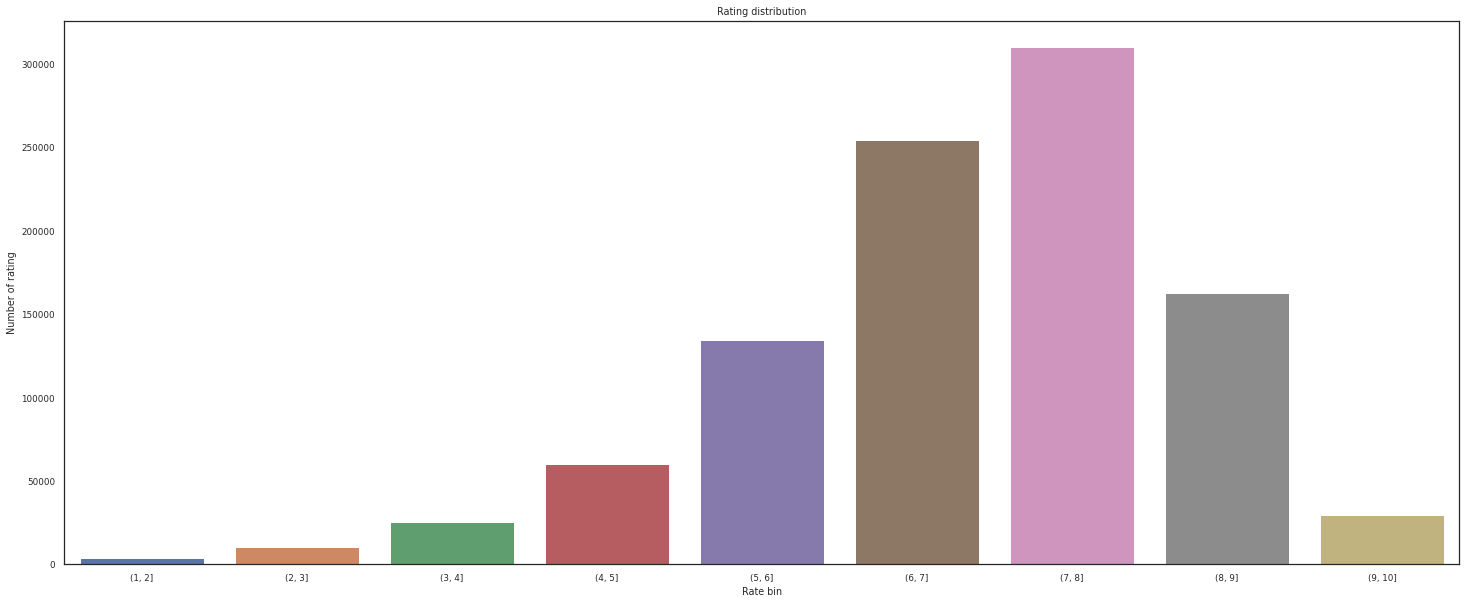

In [398]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=0.8)
ax = sns.barplot(x = rating_bins.index, y = rating_bins.values)
ax.set(title = "Rating distribution", xlabel = "Rate bin",  ylabel = "Number of rating")


In [399]:
bins2 = [1,4,7,10]
rating_bins2 = df_rating.averageRating.groupby(pd.cut(df_rating.averageRating, bins2)).count()

[Text(0, 0.5, 'Number of rating'),
 Text(0.5, 0, 'Rate bin'),
 Text(0.5, 1.0, 'Rating distribution')]

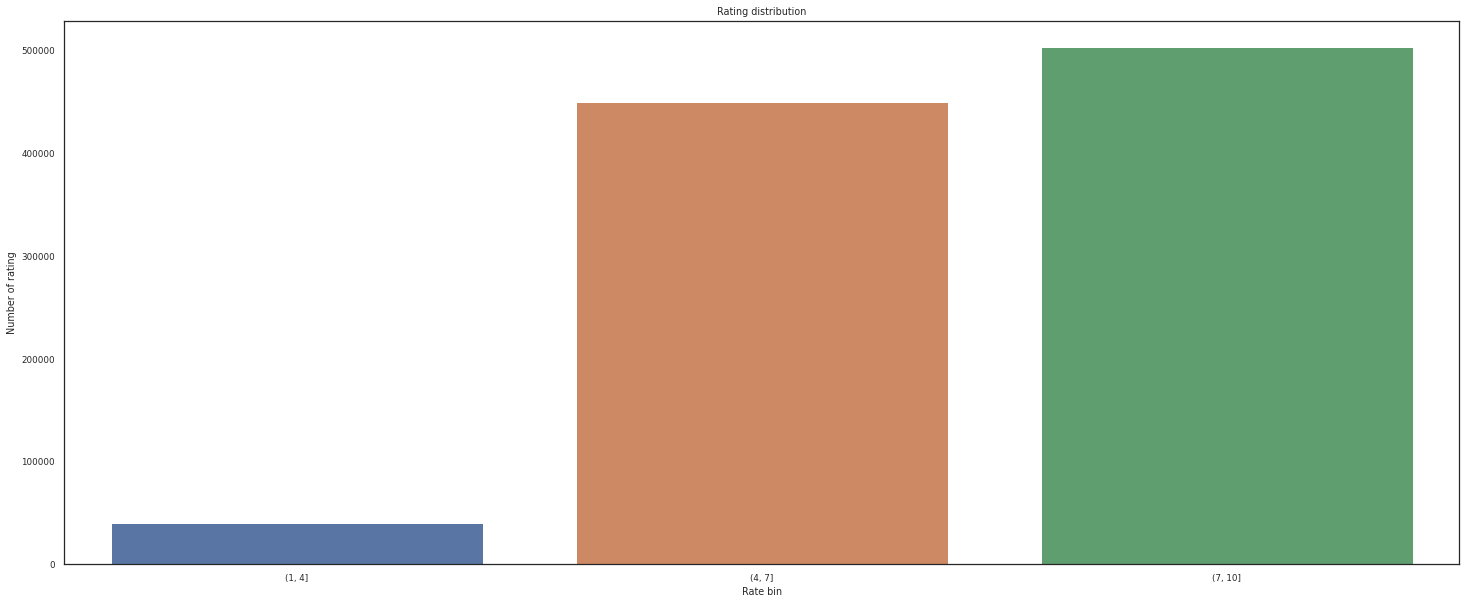

In [400]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=0.8)
ax = sns.barplot(x = rating_bins2.index, y = rating_bins2.values)
ax.set(title = "Rating distribution", xlabel = "Rate bin",  ylabel = "Number of rating")


<br>
<br>

### Movie genres




In [64]:
genres = final_df.toPandas().genres

In [75]:
from collections import defaultdict


genre_dict = defaultdict(int)

for s in genres:
  if s != "\\N":
    split = s.split(",")
    if len(split) > 1: 
      for string in split:
        genre_dict[string] += 1
    else:
      genre_dict[s]+= 1

In [199]:
import pandas as pd 
genre_df = pd.DataFrame.from_dict(dict(genre_dict) ,orient='index')
genre_df.columns = ["num_movies"]

In [200]:
genre_df.sort_values(by=['num_movies'],ascending=False, inplace=True)
#genre_df["genre"] = genre_df.index

In [215]:
genre_df

,num_movies,perc
Drama,742970,0.312923
Comedy,369762,0.155736
Action,179325,0.075528
Romance,167520,0.070556
Crime,122649,0.051657
Thriller,118859,0.050061
Horror,101455,0.042731
Adventure,88194,0.037145
Documentary,58033,0.024442
Mystery,51764,0.021802


In [234]:
genre_df["perc"]= genre_df.num_movies/genre_df.num_movies.sum()*100

In [235]:
genre_df

,num_movies,perc
Drama,742970,31.292342
Comedy,369762,15.573602
Action,179325,7.552794
Romance,167520,7.055592
Crime,122649,5.165719
Thriller,118859,5.006092
Horror,101455,4.273072
Adventure,88194,3.714547
Documentary,58033,2.444229
Mystery,51764,2.180191


[Text(0, 0.5, 'Number of films'),
 Text(0.5, 0, 'Genre'),
 Text(0.5, 1.0, 'Genre distribution')]

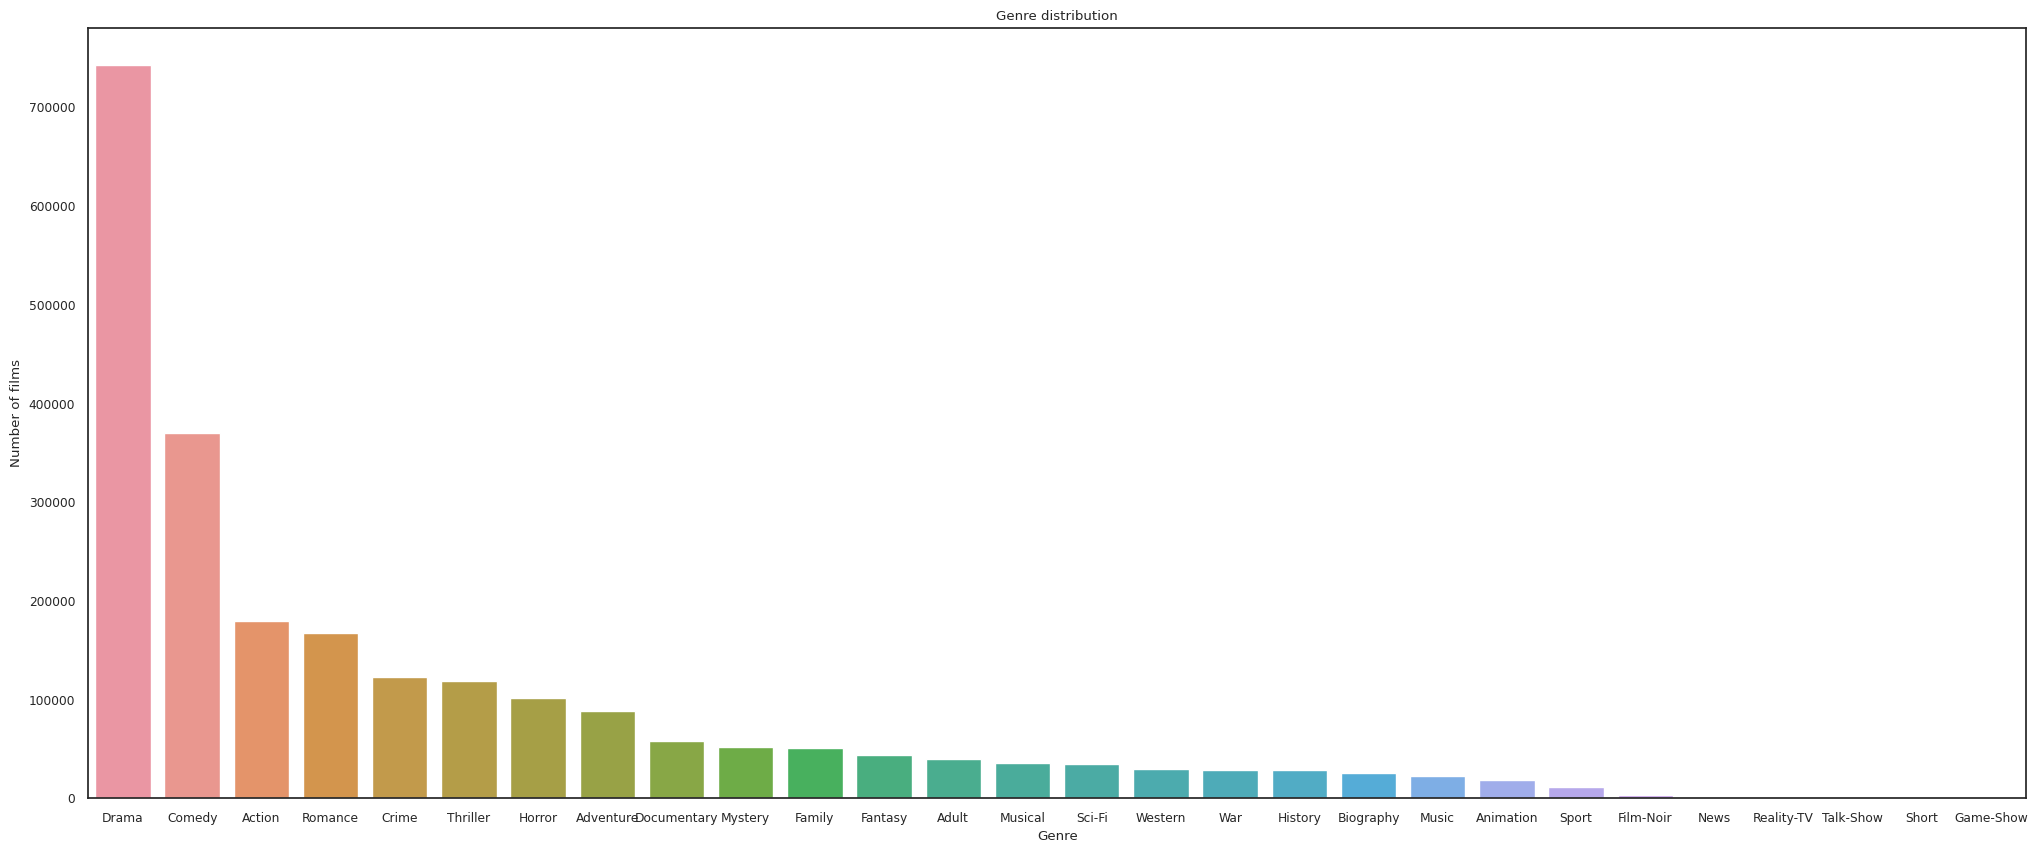

In [438]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=0.8)
ax = sns.barplot(x = genre_df.index, y = "num_movies", data = genre_df)
ax.set(title = "Genre distribution", xlabel = "Genre",  ylabel = "Number of films")


In [401]:
perc_genre_dict = {}
for k in genre_dict:
  perc_genre_dict[k] = genre_dict[k]/genre_df.num_movies.sum()*100


In [402]:
import operator
from collections import OrderedDict

sorted_tuples = sorted(perc_genre_dict.items(), key=operator.itemgetter(1),reverse= True)
print(sorted_tuples)  # [(1, 1), (3, 4), (2, 9)]

sorted_dict = OrderedDict()
for k, v in sorted_tuples:
    sorted_dict[k] = v

print(sorted_dict)

[('Drama', 31.29234165878009), ('Comedy', 15.573601674944943), ('Action', 7.552793743974506), ('Romance', 7.055591847152429), ('Crime', 5.16571922433977), ('Thriller', 5.0060923553049825), ('Horror', 4.273072294966869), ('Adventure', 3.7145467249746975), ('Documentary', 2.444228519972522), ('Mystery', 2.1801913585004677), ('Family', 2.136136027363162), ('Fantasy', 1.8555465282840702), ('Adult', 1.6681639582746315), ('Musical', 1.5130437053313268), ('Sci-Fi', 1.4510461456428814), ('Western', 1.2327069136966171), ('War', 1.222345908476945), ('History', 1.1926527837620304), ('Biography', 1.0727852193100498), ('Music', 0.9392293349540304), ('Animation', 0.7774544526419932), ('Sport', 0.4807759129372312), ('Film-Noir', 0.13477730367053353), ('News', 0.04881465467317136), ('Reality-TV', 0.010824302201039722), ('Talk-Show', 0.0027797818882047535), ('Short', 0.001811070018072794), ('Game-Show', 0.0009265939627349179)]
OrderedDict([('Drama', 31.29234165878009), ('Comedy', 15.573601674944943), (

In [410]:
dic = sorted_dict

import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'Others' if (dic[k]<1) else k):
     newdic[key] = sum([dic[k] for k in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

perc_df = pd.DataFrame(sizes,labels, columns=["perc"])

In [411]:
perc_df

,perc
Drama,31.292342
Comedy,15.573602
Action,7.552794
Romance,7.055592
Crime,5.165719
Thriller,5.006092
Horror,4.273072
Adventure,3.714547
Documentary,2.444229
Mystery,2.180191


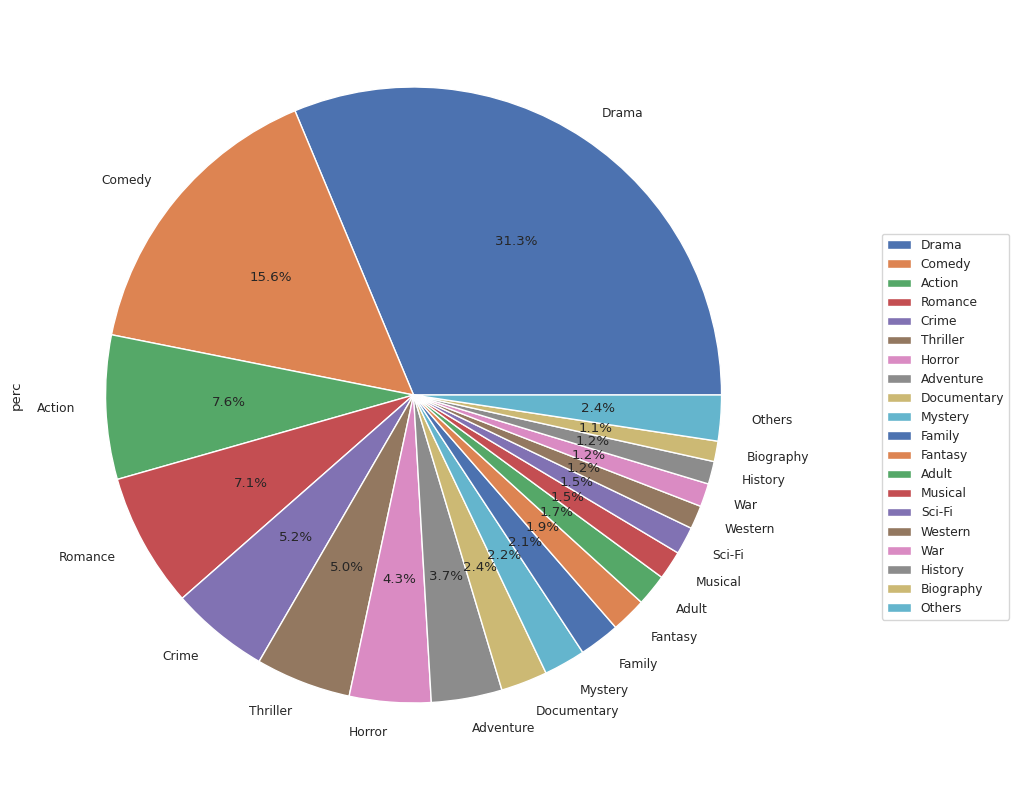

In [440]:
perc_df.plot.pie(autopct="%.1f%%", y = "perc").legend(loc="lower left", bbox_to_anchor=(1.1, 0.2), ncol= 1)

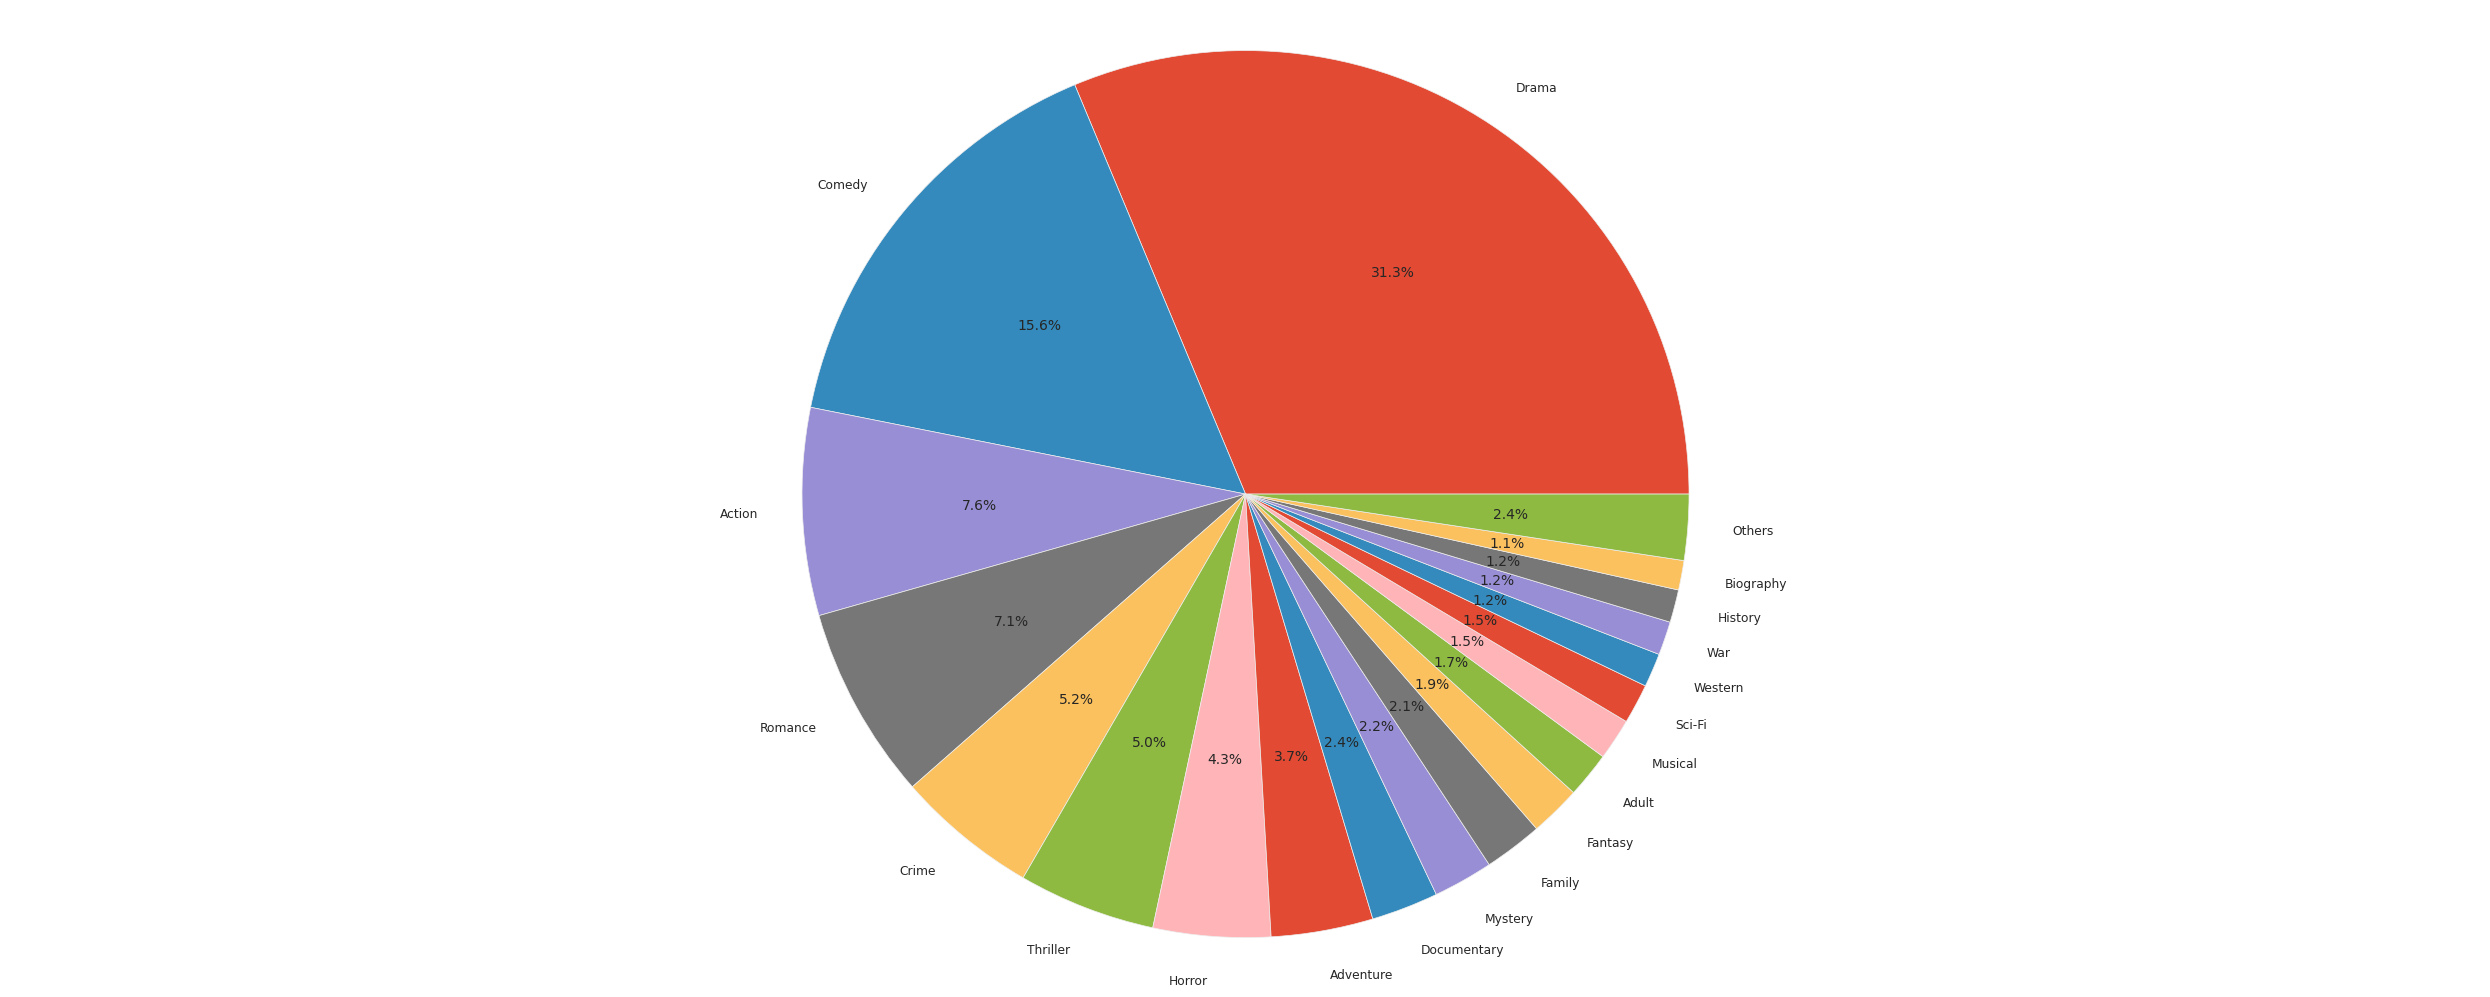

In [441]:
plt.style.use('ggplot')


fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0)
ax.axis('equal')
plt.tight_layout()

plt.show()



<br>
<br>

### Movies with more actors

In [55]:
query = """SELECT primaryTitle, count(primaryTitle) AS num_actors
           from mergedataset
           group by primaryTitle
           ORDER BY num_actors DESC
           LIMIT 10
           """
res1 = spark.sql(query)
ds = res1.toPandas()
res1.show()

+------------+----------+
|primaryTitle|num_actors|
+------------+----------+
|      Hamlet|       145|
|     Macbeth|       140|
|   Honeymoon|       139|
|      Broken|       131|
|       Alone|       128|
|        Love|       127|
|      Desire|       125|
|      Mother|       123|
|  Homecoming|       117|
|     Revenge|       115|
+------------+----------+



[Text(0, 0.5, 'Number of actors'),
 Text(0.5, 0, 'Movie title'),
 Text(0.5, 1.0, 'Movies with more actors')]

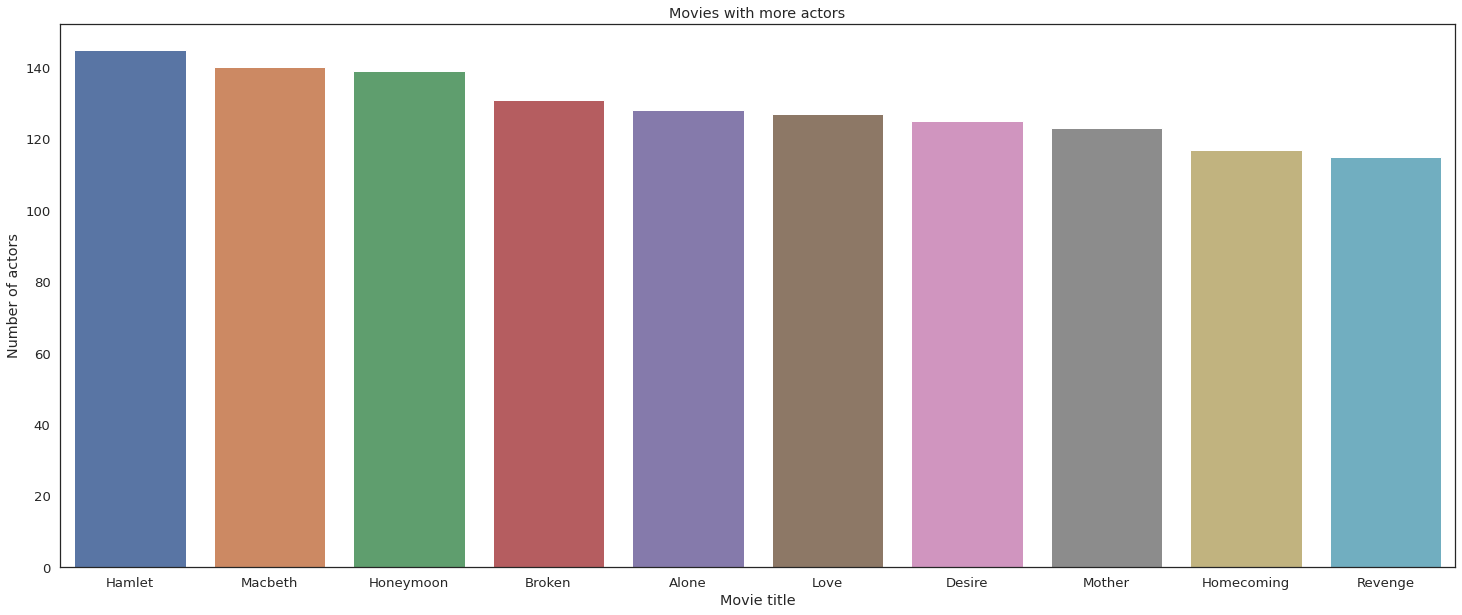

In [157]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.2)
ax = sns.barplot(x = "primaryTitle", y = "num_actors", data = ds)
ax.set(title = "Movies with more actors", xlabel = "Movie title",  ylabel = "Number of actors")


In [57]:
°query = """SELECT primaryTitle, primaryName, nconst
           from mergedataset
           where primaryTitle = 'Hamlet'
           """
spark.sql(query).show()

+------------+--------------------+---------+
|primaryTitle|         primaryName|   nconst|
+------------+--------------------+---------+
|      Hamlet|      Lara Gilchrist|nm1968493|
|      Hamlet|      Gillian Barber|nm0053390|
|      Hamlet|        Bruce Ramsay|nm0708873|
|      Hamlet|     Peter Wingfield|nm0935057|
|      Hamlet|        Helen Mirren|nm0000545|
|      Hamlet|       Quentin Crisp|nm0187998|
|      Hamlet|       Barry Stanton|nm0822719|
|      Hamlet|      Vladek Sheybal|nm0792996|
|      Hamlet|        Tim Campbell|nm8002435|
|      Hamlet|      Adrienne Gould|nm0332306|
|      Hamlet|          Tom Rooney|nm6203587|
|      Hamlet|       Seana McKenna|nm0571426|
|      Hamlet|      Thomas Olajide|nm4731835|
|      Hamlet|       Jonathan Goad|nm1770824|
|      Hamlet|    Mikhail Nazvanov|nm0623442|
|      Hamlet|Innokentiy Smoktu...|nm0810550|
|      Hamlet|        Elza Radzina|nm0705952|
|      Hamlet|      Yuriy Tolubeev|nm0866264|
|      Hamlet|    Vasiko Bakhtadze

<br>
<br>

### Actors play in more movies

In [58]:
query = """select primaryName, count(primaryName) as num_movies
           from mergedataset
           group by primaryName
            ORDER BY num_movies DESC
            LIMIT 10
           """
res = spark.sql(query)
ds2 = res.toPandas()
res.show()

+----------------+----------+
|     primaryName|num_movies|
+----------------+----------+
|    Brahmanandam|       798|
|     Adoor Bhasi|       585|
|Matsunosuke Onoe|       565|
|    Eddie Garcia|       507|
|      Prem Nazir|       438|
|    Sung-il Shin|       411|
|    Paquito Diaz|       391|
|Masayoshi Nogami|       387|
|       Mammootty|       381|
|  Aachi Manorama|       355|
+----------------+----------+



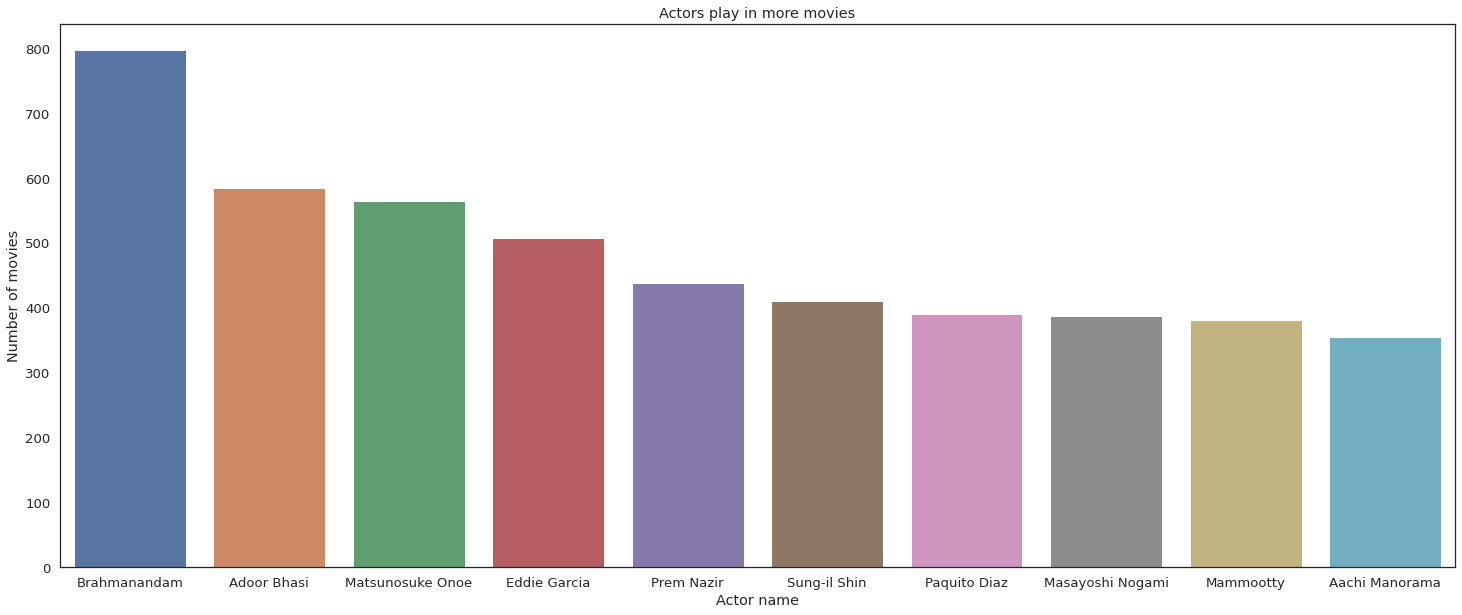

In [158]:
sns.set(rc={'figure.figsize':(25,10)}, style="white", font_scale=1.2)
ax = sns.barplot(x = "primaryName", y = "num_movies", data = ds2)
ax.set(title = "Actors play in more movies", xlabel = "Actor name", ylabel = "Number of movies");

<br>
<br>

### Number of Actors still alive and dead

In [60]:
x = final_df.select("deathYear").toPandas().head(10)

In [ ]:
for i in x:
  print(x[i])

0    1945
1    1932
2    1916
3    1960
4    1936
5      \N
6      \N
7      \N
8    1930
9    1953
Name: deathYear, dtype: object


In [ ]:
x.deathYear[5]

'\\N'

In [ ]:
query = """select deathYear
           from mergedataset
           where  deathYear = '\\N'
           """
spark.sql(query).show()

+---------+
|deathYear|
+---------+
+---------+



<br>
<br>

# Market Basket Analysis

In [ ]:
final_df.select("tconst","primaryName").show(200)

+---------+--------------------+
|   tconst|         primaryName|
+---------+--------------------+
|tt0002591|       Harry Liedtke|
|tt0002591|Martha Angerstein...|
|tt0003689| George W. Middleton|
|tt0003689|      Beulah Poynter|
|tt0003689|         John Bowers|
|tt0003689|      Mrs. E. Walton|
|tt0003689|        Octave Luzon|
|tt0003689|       Wilbur Hudson|
|tt0003689|   William S. Rising|
|tt0004272|        Harry Schumm|
|tt0004272|        Wilbur Higby|
|tt0004272|        Francis Ford|
|tt0004272|        Edgar Keller|
|tt0004272|          Burton Law|
|tt0004272|        Eddie Boland|
|tt0004272|       Jean Hathaway|
|tt0004272|        Grace Cunard|
|tt0004272|      Ernest Shields|
|tt0004336|   Florence La Badie|
|tt0004336|       Sidney Bracey|
|tt0004336|    Frank Farrington|
|tt0004336|     Marguerite Snow|
|tt0004336|         James Cruze|
|tt0005209|   DeWolf Hopper Sr.|
|tt0005209|          Julia Faye|
|tt0005209|         Fay Tincher|
|tt0005209|        Max Davidson|
|tt0005209

In [ ]:
df = final_df.select("tconst","primaryName")

In [ ]:
df.show(10)

+---------+--------------------+
|   tconst|         primaryName|
+---------+--------------------+
|tt0002591|       Harry Liedtke|
|tt0002591|Martha Angerstein...|
|tt0003689| George W. Middleton|
|tt0003689|      Beulah Poynter|
|tt0003689|         John Bowers|
|tt0003689|      Mrs. E. Walton|
|tt0003689|        Octave Luzon|
|tt0003689|       Wilbur Hudson|
|tt0003689|   William S. Rising|
|tt0004272|        Harry Schumm|
+---------+--------------------+
only showing top 10 rows



In [ ]:
baskets = df.groupBy('tconst').agg(collect_set('primaryName').alias('items'))

In [ ]:
baskets.show(200)

+---------+--------------------+
|   tconst|               items|
+---------+--------------------+
|tt0002591|[Harry Liedtke, M...|
|tt0003689|[William S. Risin...|
|tt0004272|[Wilbur Higby, Fr...|
|tt0004336|[Marguerite Snow,...|
|tt0005209|[DeWolf Hopper Sr...|
|tt0005605|[Arthur Bauer, Mi...|
|tt0005793|[Flora Morris, Wi...|
|tt0006204|[George Periolat,...|
|tt0006207|[Hal Forde, Helen...|
|tt0006441|[Martin Kinney, D...|
|tt0006489|[Dorothy Dalton, ...|
|tt0006587|[Adele Farrington...|
|tt0006819|[Max Ruhbeck, Eri...|
|tt0007011|[Howard Davies, J...|
|tt0007565|[Ronald Squire, L...|
|tt0007694|[Madge Evans, Ine...|
|tt0008160|[Murdock MacQuarr...|
|tt0008407|[Harold Lockwood,...|
|tt0008522|[James Harris, Vi...|
|tt0008661|[Tasya Borman, Ni...|
|tt0008785|[Arthur Ashley, J...|
|tt0008893|[Blanche Hines, H...|
|tt0009455|[Ormi Hawley, Hen...|
|tt0009962|[Charles Bryant, ...|
|tt0010060|[Bert Woodruff, R...|
|tt0010179|[Helen Dunbar, Be...|
|tt0010670|[Ralph Kellard, R...|
|tt0010898

In [ ]:
baskets.toPandas().head(50)

,tconst,items
0,tt0002591,"[Harry Liedtke, Martha Angerstein-Licho]"
1,tt0003689,"[William S. Rising, Beulah Poynter, Octave Luz..."
2,tt0004272,"[Wilbur Higby, Francis Ford, Harry Schumm, Ern..."
3,tt0004336,"[Marguerite Snow, Frank Farrington, Florence L..."
4,tt0005209,"[DeWolf Hopper Sr., Julia Faye, Fay Tincher, R..."
5,tt0005605,"[Arthur Bauer, Minnie Berlin, Nolan Gane, Elli..."
6,tt0005793,"[Flora Morris, Wingold Lawrence]"
7,tt0006204,"[George Periolat, Richard Bennett, Rhoda Lewis..."
8,tt0006207,"[Hal Forde, Helen Lindroth, Francesca Cappelan..."
9,tt0006441,"[Martin Kinney, Doris Pawn, George Walsh, Jame..."


In [ ]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.00005, minConfidence=0)
model = fpGrowth.fit(baskets)



In [ ]:
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")
mostPopularItemInABasket.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|  [Gérard Depardieu]| 154|
|      [Brooke Adams]|  20|
|    [E. Alyn Warren]|  25|
|    [Rae Dawn Chong]|  27|
| [Aleksandr Abdulov]|  47|
|  [Miguel Rodriguez]|  39|
|  [Vsevolod Safonov]|  24|
| [Vladimir Samoylov]|  38|
|     [Jorge Reynoso]| 121|
|  [Richard Cummings]|  22|
|       [Gina Alajar]| 105|
|     [Zandro Zamora]|  37|
|        [Süha Dogan]|  63|
|         [Jean Davy]|  24|
|[Aitana Sánchez-G...|  32|
|      [Christine Ng]|  21|
|      [Britt Morgan]|  31|
|[Dhiraj Bhattacha...|  60|
|        [Harry Baur]|  45|
|          [Lei Zhao]|  57|
+--------------------+----+
only showing top 20 rows



In [ ]:
query = """select items, freq
           from mostPopularItemInABasket
           where size(items) > 2
           order by freq desc
           limit 20"""
spark.sql(query).show()



+--------------------+----+
|               items|freq|
+--------------------+----+
|[Kitsuraku Arashi...| 112|
|[Suminojo Ichikaw...| 100|
|[Suminojo Ichikaw...|  95|
|[Suminojo Ichikaw...|  87|
|[Suminojo Ichikaw...|  86|
|[Sen'nosuke Nakam...|  80|
|[Jayabharati, Bah...|  75|
|[Thikkurisi Sukum...|  74|
|[Sen'nosuke Nakam...|  70|
|[Hôshô Bandô, Ens...|  69|
|[Suminojo Ichikaw...|  64|
|[Sen'nosuke Nakam...|  63|
|[Sen'nosuke Nakam...|  62|
|[Jayabharati, Pre...|  62|
|[Bahadur, Prem Na...|  60|
|[Shôzô Arashi, Hô...|  60|
|[Takeo Azuma, Hid...|  58|
|[Shôzô Arashi, En...|  58|
|[Kakumatsuro Aras...|  56|
|[Suminojo Ichikaw...|  55|
+--------------------+----+



In [ ]:
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show()

+--------------------+------------------+-------------------+------------------+--------------------+
|          antecedent|        consequent|         confidence|              lift|             support|
+--------------------+------------------+-------------------+------------------+--------------------+
|         [Tom Tyler]|   [Frankie Darro]|0.22330097087378642|1046.4680998613037|5.842694345796054...|
|[Reza Beyk Imanve...|        [Ali Miri]| 0.2018348623853211|1119.0577594004394|  5.5886641568484E-5|
|[Shôzô Arashi, Hô...|     [Okuzan Asao]| 0.5098039215686274| 5017.158823529412|6.604784912639019E-5|
|         [Ric Lutze]|       [Rene Bond]|0.42424242424242425|2113.9838895281932|1.066926793580149...|
|     [Vishnuvardhan]|      [Leelavathi]|0.14383561643835616|471.84554794520545|5.334633967900745...|
|     [Vishnuvardhan]|      [Balkrishna]| 0.1917808219178082| 289.2539757518501|7.112845290534328E-5|
|     [Vishnuvardhan]|  [B.S. Dwarakish]|0.15753424657534246|1148.4071537290715|5.

In [ ]:
query = """select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence
           from associationRules
           order by confidence desc
           limit 20"""

res = spark.sql(query)
res.show()



+--------------------+------------------+----------+
|     antecedent (if)| consequent (then)|confidence|
+--------------------+------------------+----------+
|[Shôzô Arashi, Hô...|   [Ritoku Arashi]|       1.0|
|          [Champion]|      [Gene Autry]|       1.0|
|[Rihaku Arashi, C...|    [Kijaku Ôtani]|       1.0|
|[Rihaku Arashi, C...|[Matsunosuke Onoe]|       1.0|
|[Chosei Kataoka, ...|[Matsunosuke Onoe]|       1.0|
|       [Larry Simms]| [Penny Singleton]|       1.0|
|       [Larry Simms]|     [Arthur Lake]|       1.0|
|[Masao Ômura, Tak...| [Kaichi Yamamoto]|       1.0|
|[Utae Nakamura, S...|[Matsunosuke Onoe]|       1.0|
|[Chosei Kataoka, ...|[Matsunosuke Onoe]|       1.0|
|[Chosei Kataoka, ...|[Matsunosuke Onoe]|       1.0|
|       [Rajesh Kava]|  [Jigna Bhardwaj]|       1.0|
|[Utae Nakamura, C...|[Matsunosuke Onoe]|       1.0|
|[Rihaku Arashi, C...|[Matsunosuke Onoe]|       1.0|
|[Utae Nakamura, C...|    [Kijaku Ôtani]|       1.0|
|[Black Jack, Roy ...|      [Allan Lane]|     

In [ ]:
associations = model.transform(baskets)
associations.show(n=200)

+---------+--------------------+--------------------+
|   tconst|               items|          prediction|
+---------+--------------------+--------------------+
|tt0002591|[Harry Liedtke, M...|                  []|
|tt0003689|[William S. Risin...|                  []|
|tt0004272|[Wilbur Higby, Fr...|                  []|
|tt0004336|[Marguerite Snow,...|                  []|
|tt0005209|[DeWolf Hopper Sr...|                  []|
|tt0005605|[Arthur Bauer, Mi...|                  []|
|tt0005793|[Flora Morris, Wi...|                  []|
|tt0006204|[George Periolat,...|                  []|
|tt0006207|[Hal Forde, Helen...|                  []|
|tt0006441|[Martin Kinney, D...|                  []|
|tt0006489|[Dorothy Dalton, ...|                  []|
|tt0006587|[Adele Farrington...|                  []|
|tt0006819|[Max Ruhbeck, Eri...|                  []|
|tt0007011|[Howard Davies, J...|                  []|
|tt0007565|[Ronald Squire, L...|                  []|
|tt0007694|[Madge Evans, Ine